In [7]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt


In [8]:
df = pd.read_csv("cleaned_SuperMarket_Analysis.csv")

df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5%,sales,...,gross_margin_percentage,gross_income,rating,hour,calculated_sales,day,day_of_week,month,week,is_weekend
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,...,4.761905,26.1415,9.1,13,548.9715,5,Saturday,1,1,1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,...,4.761905,3.8200,9.6,10,80.2200,8,Friday,3,10,0
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,...,4.761905,16.2155,7.4,13,340.5255,3,Sunday,3,9,1
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,...,4.761905,23.2880,8.4,20,489.0480,27,Sunday,1,4,1
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,...,4.761905,30.2085,5.3,10,634.3785,8,Friday,2,6,0


In [9]:
daily_product_sales = (
    df.groupby(["date", "product_line"])
      .agg(
          daily_quantity=("quantity", "sum"),
          daily_sales=("sales", "sum")
      )
      .reset_index()
)
daily_product_sales.head()

,date,product_line,daily_quantity,daily_sales
0,2019-01-01,Electronic accessories,18,1382.745
1,2019-01-01,Fashion accessories,9,621.243
2,2019-01-01,Food and beverages,18,1066.023
3,2019-01-01,Health and beauty,2,132.027
4,2019-01-01,Home and lifestyle,8,399.756


In [10]:
daily_product_sales = daily_product_sales.sort_values(
    ["product_line", "date"]
)

daily_product_sales["expected_demand"] = (
    daily_product_sales
    .groupby("product_line")["daily_quantity"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)




In [11]:
product = "Food and beverages"   # change later for others

prophet_df = (
    daily_product_sales[daily_product_sales["product_line"] == product]
    [["date", "daily_quantity"]]
    .rename(columns={"date": "ds", "daily_quantity": "y"})
)
prophet_df.head()

,ds,y
2,2019-01-01,18
8,2019-01-02,6
21,2019-01-05,1
25,2019-01-06,15
31,2019-01-07,7


In [12]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False
)


In [13]:
model.add_country_holidays(country_name="MY")  # dataset is from Myanmar region
model.fit(prophet_df)

01:29:58 - cmdstanpy - INFO - Chain [1] start processing
01:29:58 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future = model.make_future_dataframe(periods=14)
forecast = model.predict(future)


In [15]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
85,2019-04-09,8.982153,-0.412017,18.056602
86,2019-04-10,12.095385,2.756166,22.456643
87,2019-04-11,9.684357,-0.929834,18.973669
88,2019-04-12,6.663743,-4.065487,16.261083
89,2019-04-13,9.054758,-0.930020,18.396105


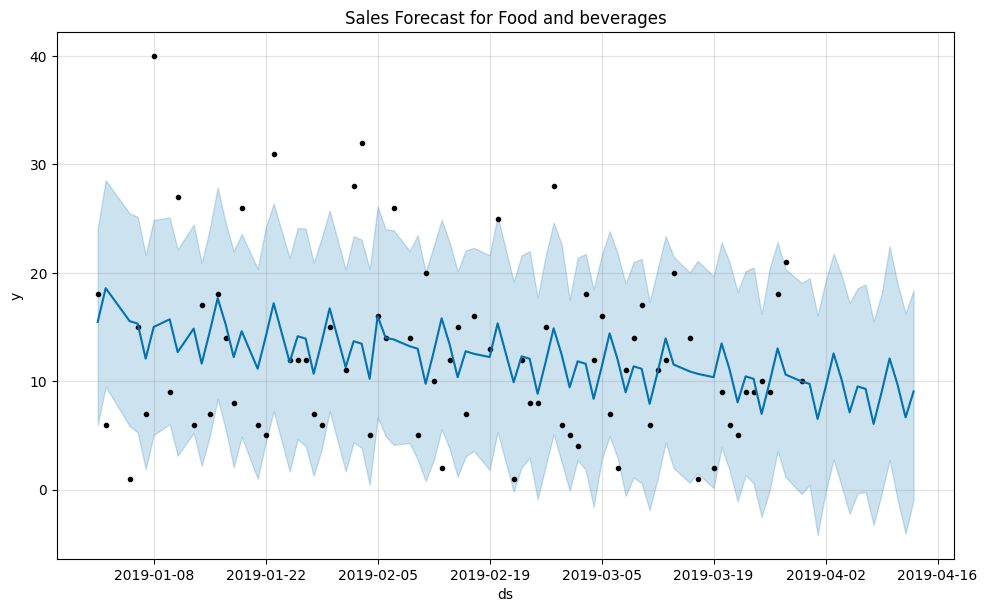

In [16]:
model.plot(forecast)
plt.title(f"Sales Forecast for {product}")
plt.show()


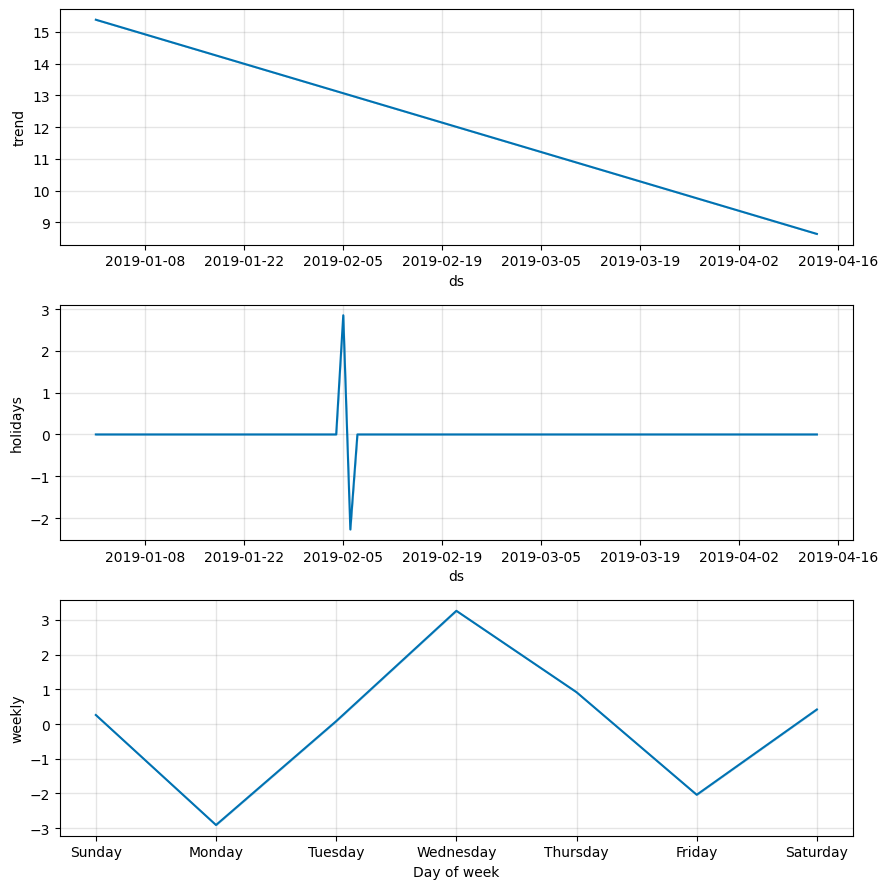

In [17]:
model.plot_components(forecast)
plt.show()


In [18]:
forecast_df = forecast[["ds", "yhat"]].rename(
    columns={"ds": "date", "yhat": "forecasted_quantity"}
)


In [19]:
# Ensure 'date' column is datetime for merging
daily_product_sales["date"] = pd.to_datetime(daily_product_sales["date"])

final_df = daily_product_sales.merge(
    forecast_df,
    on="date",
    how="left"
)


In [20]:
final_df["expected_demand_prophet"] = final_df["forecasted_quantity"].fillna(
    final_df["expected_demand"]
)
final_df.head()

,date,product_line,daily_quantity,daily_sales,expected_demand,forecasted_quantity,expected_demand_prophet
0,2019-01-01,Electronic accessories,18,1382.745,18.000000,15.467637,15.467637
1,2019-01-02,Electronic accessories,6,138.663,12.000000,18.580870,18.580870
2,2019-01-04,Electronic accessories,10,705.621,11.333333,NaN,11.333333
3,2019-01-05,Electronic accessories,7,690.018,10.250000,15.540242,15.540242
4,2019-01-07,Electronic accessories,4,326.424,9.000000,12.079408,12.079408


In [21]:
SAFETY_STOCK = 0.15

final_df["stocked_quantity_prophet"] = (
    final_df["expected_demand_prophet"] * (1 + SAFETY_STOCK)
).round()


In [22]:
final_df["waste_quantity_prophet"] = (
    final_df["stocked_quantity_prophet"] - final_df["daily_quantity"]
).clip(lower=0)


In [26]:
comparison = final_df[["waste_quantity_prophet"]].sum()

comparison



waste_quantity_prophet    2036.0
dtype: float64

In [27]:
train = prophet_df.iloc[:-14]
test = prophet_df.iloc[-14:]

# Instantiate a new Prophet model for training
from prophet import Prophet
new_model = Prophet(
	daily_seasonality=False,
	weekly_seasonality=True,
	yearly_seasonality=False
)
new_model.add_country_holidays(country_name="MY")
new_model.fit(train)

future_test = model.make_future_dataframe(periods=14)
forecast_test = model.predict(future_test)
test_forecast = forecast_test.tail(14)

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(test["y"], test_forecast["yhat"])
mape = mean_absolute_percentage_error(test["y"], test_forecast["yhat"])

mae, mape


01:34:23 - cmdstanpy - INFO - Chain [1] start processing
01:34:23 - cmdstanpy - INFO - Chain [1] done processing


(5.319012292066234, 1.2881803360304236)

In [28]:
final_df.to_csv("grocery_forecast_waste.csv", index=False)
